# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm

import os

In [5]:
# 


In [3]:
# display = pd.read_sql_query("""
# SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
# FROM Reviews
# GROUP BY UserId
# HAVING COUNT(*)>1
# """, con)

In [6]:
# print(display.shape)
# display.head()

In [7]:
# display[display['UserId']=='AZY10LLTJ71NX']

In [8]:
# display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND UserId="AR5J8UI46CURR"
# ORDER BY ProductID
# """, con)
# display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
# #Sorting data according to ProductId in ascending order
# sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
# #Deduplication of entries
# final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
# final.shape

In [12]:
# #Checking to see how much % of data still remains
# (final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND Id=44737 OR Id=64422
# ORDER BY ProductID
# """, con)

# display.head()

In [14]:
# final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
# #Before starting the next phase of preprocessing lets see the number of entries left
# print(final.shape)

# #How many positive and negative reviews are present in our dataset?
# final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# # printing some random reviews
# sent_0 = final['Text'].values[0]
# print(sent_0)
# print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

In [17]:
# # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
# sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

# print(sent_0)

In [18]:
# # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [19]:
# # https://stackoverflow.com/a/47091490/4084039
# import re

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [20]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [21]:
# #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
# sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
# print(sent_0)

In [22]:
# #remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [23]:
# # https://gist.github.com/sebleier/554280
# # we are removing the words from the stop words list: 'no', 'nor', 'not'
# # <br /><br /> ==> after the above steps, we are getting "br br"
# # we are including them into stop words list
# # instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

# stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
#             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
#             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
#             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
#             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
#             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
#             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
#             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
#             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
#             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
#             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
#             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
#             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
#             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
#             'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# # Combining all the above stundents 
# from tqdm import tqdm
# preprocessed_reviews = []
# # tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     # https://gist.github.com/sebleier/554280
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
#     preprocessed_reviews.append(sentance.strip())

In [25]:
# preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [2]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [3]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [4]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [5]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [6]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [27]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [28]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [30]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# Data Loading

In [2]:
clean_text_data=pd.read_csv("./input/Clean_data.csv")

In [4]:
clean_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [3]:
avg_w2v_df=pd.read_csv("./input/avg_w2v_df.csv")
tfidf_w2v_df=pd.read_csv("./input/tfidf_w2v_df.csv")
print(" avg_w2v_df ",avg_w2v_df.shape,"tfidf_w2v_df ",tfidf_w2v_df.shape,"clean_text_data",clean_text_data.shape)

 avg_w2v_df  (364171, 52) tfidf_w2v_df  (364171, 52) clean_text_data (364171, 11)


In [36]:
avg_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.758505,-0.172168,-0.385203,-0.241811,-0.394415,-0.073644,-0.22428,0.286488,-0.087994,-0.419489,...,-0.957424,0.008468,-0.998245,-0.097955,0.065205,-0.238957,-0.527055,0.183418,1.0,1.303862e+09


In [6]:
tfidf_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.631241,-0.058037,-0.317851,-0.147253,-0.524769,0.303866,-0.254059,0.337368,0.037931,-0.362123,...,-0.997835,0.090512,-0.722301,-0.040754,-0.208076,-0.658077,-0.648217,0.04987,1.0,1.303862e+09


In [38]:
# Checking the positive and negative labels
clean_text_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [4]:
#Spliting records into train, cv and test using based on time

def split_train_cv_test(df,sample_size):
    filter_data_positive=df[df.Score==1].sample(sample_size,random_state=17)
    filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)
    filter_data_negative=df[df.Score==0].sample(sample_size,random_state=17)
    filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)
    # Splitting Train,CV and Test for positive data
    row=filter_data_positive.shape[0]
    split=int(row*0.6)
    train_data_positive=filter_data_positive[:split]
    cv_data_positive=filter_data_positive[split:int(row*0.8)]
    test_data_positive=filter_data_positive[int(row*0.8):row]
    print("Total_positive_data",filter_data_positive.shape)
    print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)
    # Splitting Train,CV and Test for -ve data
    row=filter_data_negative.shape[0]
    split=int(row*0.6)
    train_data_negative=filter_data_negative[:split]
    cv_data_negative=filter_data_negative[split:int(row*0.8)]
    test_data_negative=filter_data_negative[int(row*0.8):row]
    print("Total_negative_data",filter_data_negative.shape)
    print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)
    # Combining +ve and -ve train data and sorting based on time
    train_data=np.vstack((train_data_positive, train_data_negative))
    train_data=pd.DataFrame(train_data)
    train_data.columns=df.columns
    train_data.sort_values(by='Time',inplace=True,ascending=True)
    print("train_data",train_data.shape)
    # Checking the positive and negative labels
    train_data['Score'].value_counts()
    # Combining +ve and -ve CV data and sorting based on time
    cv_data=np.vstack((cv_data_positive,cv_data_negative))
    cv_data=pd.DataFrame(cv_data)
    cv_data.columns=df.columns
    cv_data.sort_values(by='Time',inplace=True,ascending=True)
    print("cv_data",cv_data.shape)
    # Checking the positive and negative labels
    cv_data['Score'].value_counts()
    # Combining +ve and -ve test data and sorting based on time
    test_data=np.vstack((test_data_positive, test_data_negative))
    test_data=pd.DataFrame(test_data)
    test_data.columns=df.columns
    test_data.sort_values(by='Time',inplace=True,ascending=True)
    print("test_data",test_data.shape)
    # Checking the positive and negative labels
    test_data['Score'].value_counts()
    return train_data,cv_data,test_data

In [5]:
# splitting text data for BOW and TFIDF
train_text_data,cv_text_data,test_text_data=split_train_cv_test(clean_text_data,50000)

Total_positive_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
Total_negative_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
train_data (60000, 11)
cv_data (20000, 11)
test_data (20000, 11)


In [6]:
# splitting avg Word2Vec data
train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data=split_train_cv_test(avg_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [7]:
# splitting TFIDF Word2Vec data
train_tfidf_w2v_data,cv_tfidf_w2v_data,test_tfidf_w2v_data=split_train_cv_test(tfidf_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [43]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [44]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [45]:
train_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [8]:
# Please write all the code with proper documentation
import gc; gc.collect()
# Converting text to vector using Bag of words to all train, CV and test
count_vect = CountVectorizer(min_df=10,max_features=10000 ) #in scikit-learn
training_counts = count_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = count_vect.transform(cv_text_data['CleanedText'])
test_counts = count_vect.transform(test_text_data['CleanedText'])
gc.collect()

0

In [9]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

 training_counts  (60000, 6860) cv_counts  (20000, 6860) test_counts (20000, 6860)


In [10]:
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.85985  Acc:  85.985  auc_train  0.8714166666666666


 12%|██████████▌                                                                         | 1/8 [00:13<01:37, 13.95s/it]

 C value:  0.001  AUC:  0.84795  Acc:  84.795  auc_train  0.8464833333333334


 25%|█████████████████████                                                               | 2/8 [00:27<01:23, 13.86s/it]

 C value:  0.01  AUC:  0.7757000000000001  Acc:  77.57  auc_train  0.7701833333333333


 38%|███████████████████████████████▌                                                    | 3/8 [00:41<01:09, 13.94s/it]

 C value:  0.1  AUC:  0.5683  Acc:  56.830000000000005  auc_train  0.5657166666666666


 50%|██████████████████████████████████████████                                          | 4/8 [00:54<00:54, 13.69s/it]

 C value:  1  AUC:  0.5  Acc:  50.0  auc_train  0.5


 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:08<00:40, 13.59s/it]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:21<00:27, 13.53s/it]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:34<00:13, 13.27s/it]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.08s/it]


In [15]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values())
    plt.plot(list(train_map.keys()), train_map.values())
    plt.semilogx(alpha, train_map.values(), label='Train_Error')
    plt.semilogx(alpha, test_map.values(), label='CV_Error')
    plt.xlabel('Alpha value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.grid()
    return plt
    

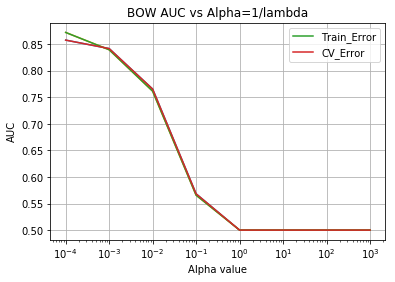

In [55]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and comperatevely low AUC on unseen data. As alpha increasing AUC on Unseen data increasing till best hyperparamter c=0.001 after that model started underfitting so AUC on Test and train data started decreasing. Hence our best alpha is 0.001. 

In [27]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=0.001
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(training_count, train_traget)

# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.001  AUC:  0.8366999999999999  Acc:  83.67


In [20]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

In [16]:
def plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count):
    # ROC AUC Curve
    y_true_train = train_traget
    y_probas_train = clf.predict_proba(training_count)
    y_true_test = test_target
    y_probas_test = clf.predict_proba(test_count)
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

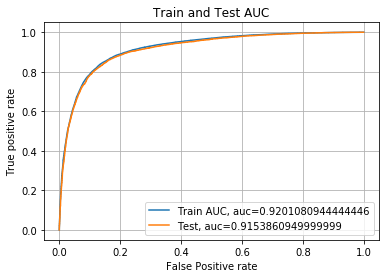

In [23]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is overlapping on best hyperparamter alpha =0.001. And the diff of train and Test AUC is minimal so we can say that this model is well fit. If we need better performance than this we may need to try different complex models and add some new features.

In [17]:
# Plotting Confusion matrix on test data
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plotconfusionMatrix(y_true_test,clf,test_count):
    ax= plt.subplot()
    confm = confusion_matrix(y_true_test, clf.predict(test_count))
    sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix of Test data'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

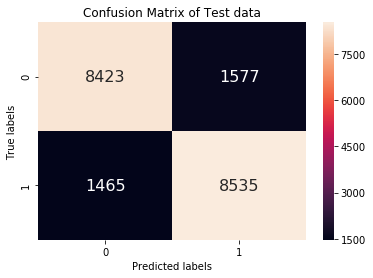

In [25]:
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

# Applying Linear SVM on BOW, using L2 regularization

In [50]:
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.86225  Acc:  86.225  auc_train  0.8874166666666666


 12%|██████████▌                                                                         | 1/8 [00:12<01:25, 12.21s/it]

 C value:  0.001  AUC:  0.87095  Acc:  87.095  auc_train  0.8899666666666666


 25%|█████████████████████                                                               | 2/8 [00:21<01:08, 11.48s/it]

 C value:  0.01  AUC:  0.8663500000000001  Acc:  86.63499999999999  auc_train  0.8714666666666667


 38%|███████████████████████████████▌                                                    | 3/8 [00:32<00:55, 11.15s/it]

 C value:  0.1  AUC:  0.82085  Acc:  82.085  auc_train  0.8206833333333333


 50%|██████████████████████████████████████████                                          | 4/8 [00:42<00:42, 10.72s/it]

 C value:  1  AUC:  0.5473999999999999  Acc:  54.74  auc_train  0.55005


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:52<00:31, 10.56s/it]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5001666666666666


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:01<00:20, 10.25s/it]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:11<00:10, 10.09s/it]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:21<00:00,  9.96s/it]


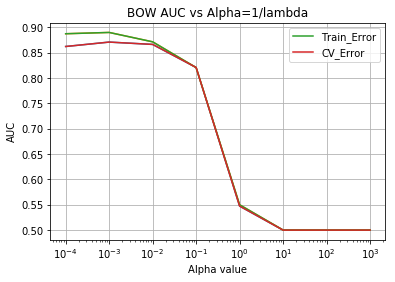

In [53]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and low AUC on unseen data. As alpha increasing AUC on Unseen data increasing till best hyperparamter c=0.01 after that model started underfitting so AUC on train and Test data started decreasing. Hence our best C is 0.01.


In [54]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=0.01
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(training_count, train_traget)

# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.01  AUC:  0.8653000000000001  Acc:  86.53


In [55]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

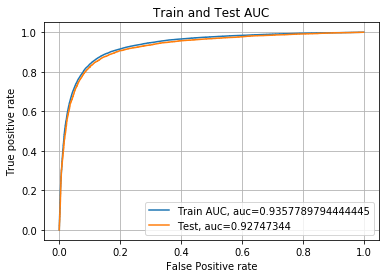

In [56]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter alpha =0.01. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features


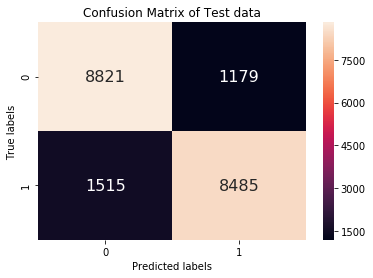

In [57]:
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try complex models and add some new features.


# Feature Importance

In [29]:
feature_data=pd.DataFrame(list(LGR.coef_.T),columns=['true_weights'])
features=(count_vect.get_feature_names())
feature_data['Feature_name']=features

In [36]:
# Important features for +ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=False)

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

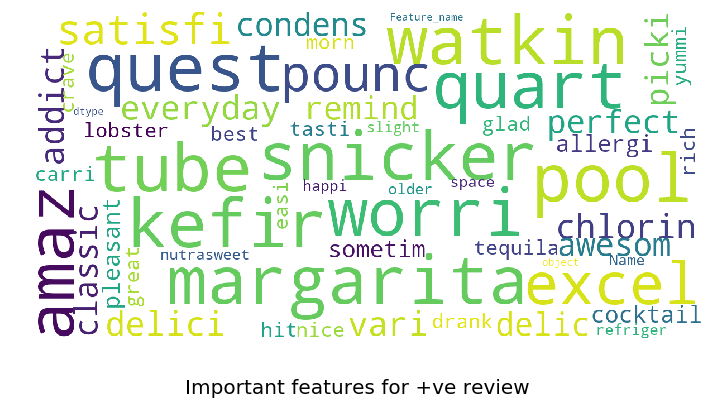

In [33]:
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for +ve review")

**Observation**

We can see that all the positive words in the above word cloud like amaz, satisfy, delici so these words are important features for positive review.


In [38]:
# Important features for -ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=True)
feature_data.head()

,true_weights,Feature_name
6757,-13.396082,worst
2890,-10.499523,horribl
367,-7.768531,aw
849,-7.261802,canola
1714,-7.021379,disgust


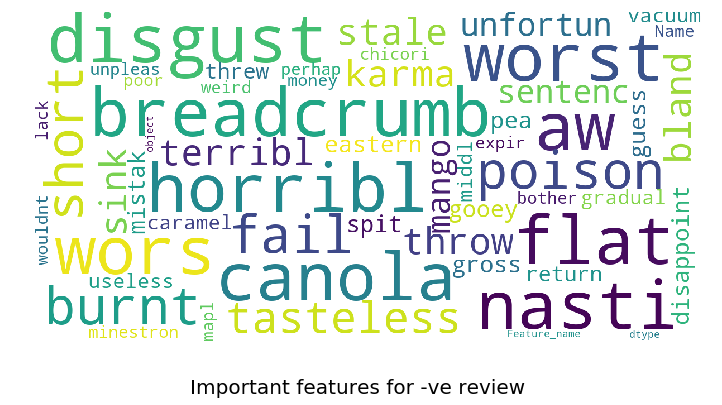

In [39]:
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for -ve review")

**Observation**

We can see that all the negative words in the above wordcloud like tasteless, worst, poor so these words are important features for negative review.


# Feature Engineering

    Creating 4 new features using word and character len of description and summary columns

In [40]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,6850,6851,6852,6853,6854,6855,6856,6857,6858,6859
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
data.shape

(60000, 6860)

In [42]:
#Train data
# word len of description and summary columns
data['description_len'] = train_text_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_text_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_text_data['Summary'].apply(len)

In [43]:
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,6854,6855,6856,6857,6858,6859,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,1,61,5


In [44]:
data.shape

(60000, 6864)

In [45]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_text_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_text_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_text_data['Summary'].apply(len)
data_test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,6854,6855,6856,6857,6858,6859,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,29,2,163,7


In [46]:
data_test.shape

(20000, 6864)

In [48]:
# with l1 regularizer

best_alpha=0.001
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(data, train_traget)
# Prediction on Test data
pred = LGR.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.001  AUC:  0.7834500000000001  Acc:  78.345


In [58]:
# with l2 regularizer

best_alpha=0.01
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(data, train_traget)
# Prediction on Test data
pred = LGR.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.01  AUC:  0.7534500000000001  Acc:  75.345


**Observation**

After adding the 4 new features, performance has reduced with both l1 and l2 regularizer, earlier we have 90 to 92% AUC and after feature engineering we are getting 75 to 78%, may be we need to tune the hyperparameter further.

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [59]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=10000)
training_counts = tf_idf_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = tf_idf_vect.transform(cv_text_data['CleanedText'])
test_counts = tf_idf_vect.transform(test_text_data['CleanedText'])

In [60]:

print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
# converting sparse vector to dense vector
training_count=training_counts.toarray()
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()

 training_counts  (60000, 10000) cv_counts  (20000, 10000) test_counts (20000, 10000)


19125

In [61]:
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

In [63]:
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 C value:  1e-05  AUC:  0.8219  Acc:  82.19  auc_train  0.8695166666666666



 11%|█████████▎                                                                          | 1/9 [00:28<03:45, 28.22s/it]

 C value:  0.0001  AUC:  0.80805  Acc:  80.805  auc_train  0.8183666666666667



 22%|██████████████████▋                                                                 | 2/9 [00:42<02:49, 24.16s/it]

 C value:  0.001  AUC:  0.63455  Acc:  63.455  auc_train  0.6272333333333333



 33%|████████████████████████████                                                        | 3/9 [00:57<02:07, 21.23s/it]

 C value:  0.01  AUC:  0.5  Acc:  50.0  auc_train  0.5



 44%|█████████████████████████████████████▎                                              | 4/9 [01:11<01:35, 19.16s/it]

 C value:  0.1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:26<01:10, 17.72s/it]

 C value:  1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 67%|████████████████████████████████████████████████████████                            | 6/9 [01:40<00:50, 16.73s/it]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:55<00:32, 16.18s/it]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:10<00:15, 16.00s/it]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:27<00:00, 16.06s/it]

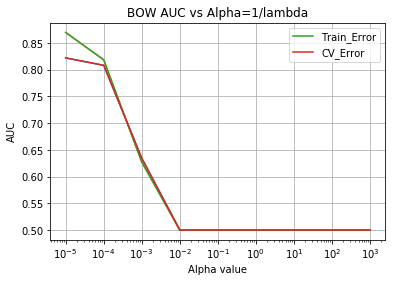

In [64]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation** 

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=0.0001 after that model started underfitting so AUC on train and Test data started decreasing. Hence our best alpha is 0.0001 for l1 regularizer.

In [65]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=0.0001
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(training_count, train_traget)

# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.0001  AUC:  0.8518499999999999  Acc:  85.185


In [66]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

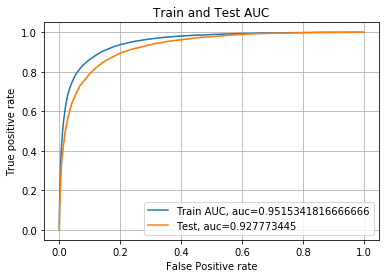

In [67]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter alpha =0.0001. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features

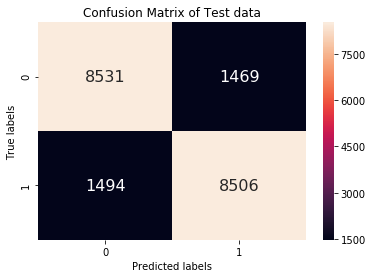

In [68]:
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try complex models and add some new features.

In [69]:
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 C value:  1e-05  AUC:  0.8051  Acc:  80.51  auc_train  0.8353833333333335



 11%|█████████▎                                                                          | 1/9 [00:07<01:02,  7.87s/it]

 C value:  0.0001  AUC:  0.84905  Acc:  84.905  auc_train  0.8780666666666667



 22%|██████████████████▋                                                                 | 2/9 [00:17<00:58,  8.43s/it]

 C value:  0.001  AUC:  0.8070499999999998  Acc:  80.705  auc_train  0.8163333333333334



 33%|████████████████████████████                                                        | 3/9 [00:28<00:55,  9.30s/it]

 C value:  0.01  AUC:  0.50005  Acc:  50.005  auc_train  0.5000666666666667



 44%|█████████████████████████████████████▎                                              | 4/9 [00:39<00:48,  9.62s/it]

 C value:  0.1  AUC:  0.50115  Acc:  50.114999999999995  auc_train  0.50075



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:49<00:39,  9.83s/it]

 C value:  1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:59<00:29,  9.88s/it]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:12<00:21, 10.69s/it]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [01:23<00:10, 10.76s/it]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:34<00:00, 10.88s/it]

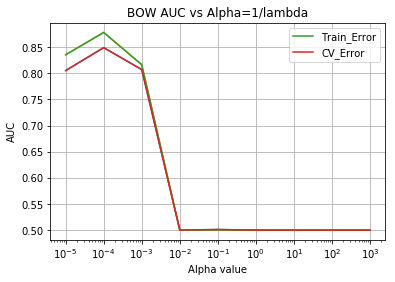

In [70]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=0.001 after that model started underfitting so AUC on train and Test data started decreasing. Hence our best alpha is 0.001 for l2 regularizer.

In [77]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=0.001
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2',n_jobs=-1)
#LGR = CalibratedClassifierCV(LGR)
LGR.fit(training_count, train_traget)

# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.001  AUC:  0.8264500000000001  Acc:  82.645


In [73]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

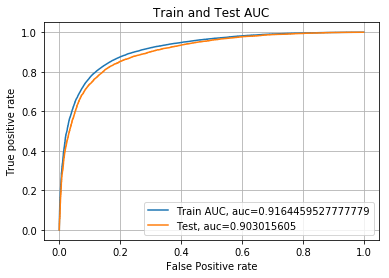

In [74]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter alpha =0.001. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features

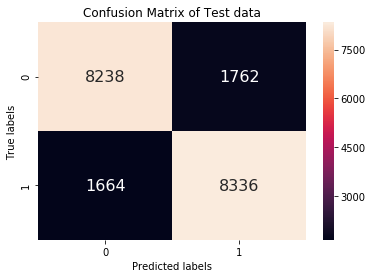

In [75]:
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try complex models and add some new features.

In [78]:
# Please write all the code with proper documentation
feature_data=pd.DataFrame(list(LGR.coef_.T),columns=['true_weights'])
feature_data['Feature_name']=tf_idf_vect.get_feature_names()
feature_data.head()

,true_weights,Feature_name
0,0.316189,abl buy
1,0.004872,abl drink
2,-0.027730,abl eat
3,0.031522,abl enjoy
4,0.513219,abl find


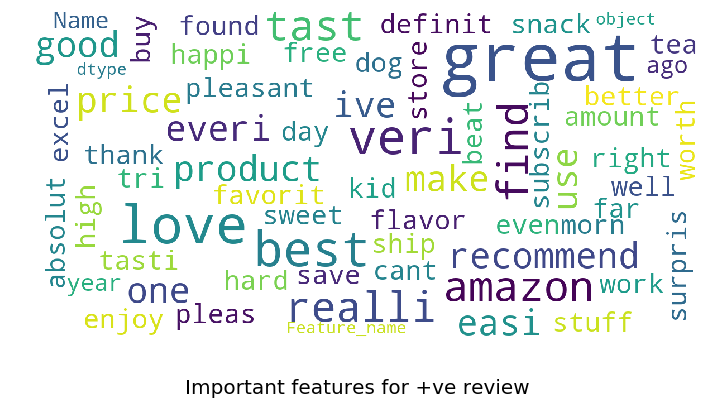

In [79]:
# Important features for +ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=False)
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for +ve review")

**Observation**

We can see that all the positive words in the above word cloud like testi, best, awesom so these words are important features for positive review.

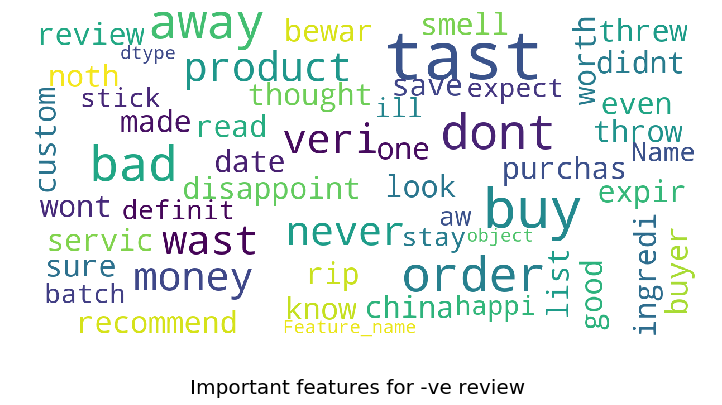

In [80]:
# Please write all the code with proper documentation
# Important features for -ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=True)
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for -ve review")

**Observation**

We can see that all the negative words in the above wordcloud like tasteless, worst, refurnd so these words are important features for negative review.

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [95]:
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_avg_w2v_data['Score'].astype('int')
cv_target=cv_avg_w2v_data['Score'].astype('int')
test_target=test_avg_w2v_data['Score'].astype('int')

train_data = train_avg_w2v_data.iloc[:,:-2]
cv_data = cv_avg_w2v_data.iloc[:,:-2]
test_data = test_avg_w2v_data.iloc[:,:-2]

In [42]:
train_avg_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.072261,-0.631519,1.198363,0.29545,0.123251,-1.53865,0.494211,0.498906,-0.04214,-0.516918,...,0.558099,-0.098661,-0.087573,1.054245,1.093834,0.375699,0.012794,0.076482,0.0,948240000.0


In [72]:
# Please write all the code with proper documentation
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.5105000000000001  Acc:  51.05  auc_train  0.5053888888888889



 12%|██████████▌                                                                         | 1/8 [00:00<00:01,  4.20it/s]

 C value:  0.001  AUC:  0.4995  Acc:  49.95  auc_train  0.5012777777777777



 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  4.32it/s]

 C value:  0.01  AUC:  0.5  Acc:  50.0  auc_train  0.5



 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:01,  4.32it/s]

 C value:  0.1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00,  4.41it/s]

 C value:  1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:01<00:00,  4.17it/s]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  4.21it/s]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:01<00:00,  4.21it/s]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.08it/s]

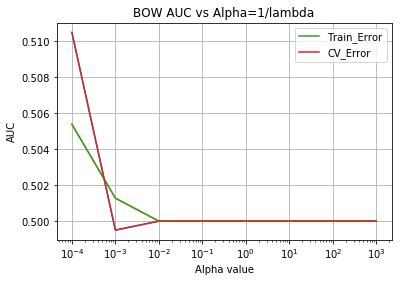

In [73]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation** 

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=0.01 after that model started underfitting so AUC on train and Test data started decreasing. Hence our best alpha is 0.01 for l1 regularizer.

In [91]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=0.1
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(train_data, train_traget)

# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.1  AUC:  0.4925  Acc:  49.25


In [92]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

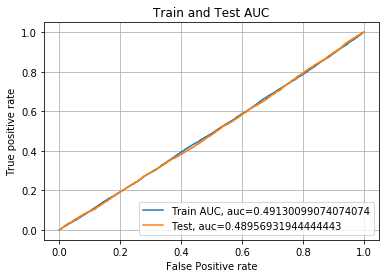

In [93]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =0.01. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

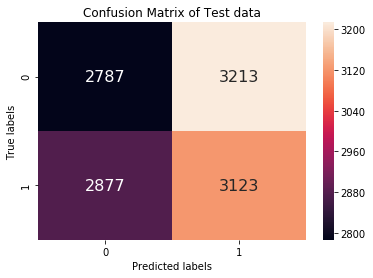

In [94]:
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

In [78]:
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 C value:  1e-05  AUC:  0.5059166666666666  Acc:  50.59166666666667  auc_train  0.5023333333333333



 11%|█████████▎                                                                          | 1/9 [00:00<00:01,  6.79it/s]

 C value:  0.0001  AUC:  0.4993333333333334  Acc:  49.93333333333334  auc_train  0.4996388888888889



 22%|██████████████████▋                                                                 | 2/9 [00:00<00:01,  6.71it/s]

 C value:  0.001  AUC:  0.49158333333333326  Acc:  49.15833333333333  auc_train  0.5045833333333333



 33%|████████████████████████████                                                        | 3/9 [00:00<00:00,  6.53it/s]

 C value:  0.01  AUC:  0.5039166666666666  Acc:  50.391666666666666  auc_train  0.5121111111111111



 44%|█████████████████████████████████████▎                                              | 4/9 [00:00<00:00,  6.52it/s]

 C value:  0.1  AUC:  0.5063333333333333  Acc:  50.63333333333333  auc_train  0.5095555555555555



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:00<00:00,  6.37it/s]

 C value:  1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:00<00:00,  6.57it/s]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:01<00:00,  6.59it/s]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:01<00:00,  6.34it/s]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.07it/s]

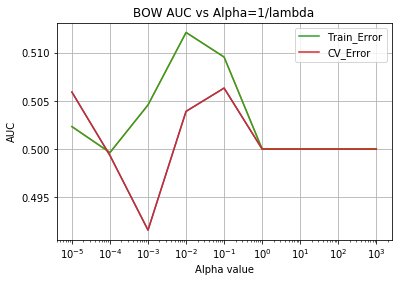

In [79]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=1 after that model started underfitting so AUC on train and Test data started decreasing. Hence our best alpha is 1 for l2 regularizer.

In [81]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=0.1
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(train_data, train_traget)

# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.1  AUC:  0.49  Acc:  49.0


In [82]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

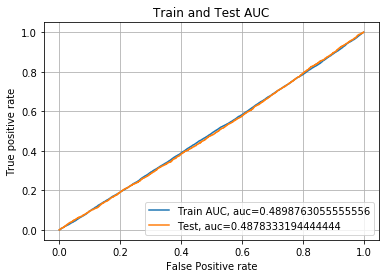

In [83]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =1. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

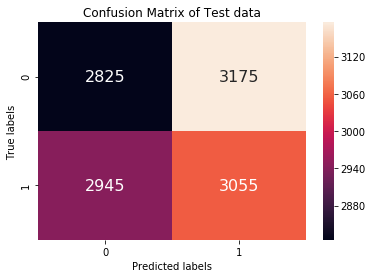

In [84]:
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [55]:
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_tfidf_w2v_data['Score'].astype('int')
cv_target=cv_tfidf_w2v_data['Score'].astype('int')
test_target=test_tfidf_w2v_data['Score'].astype('int')

train_data = train_tfidf_w2v_data.iloc[:,:-2]
cv_data = cv_tfidf_w2v_data.iloc[:,:-2]
test_data = test_tfidf_w2v_data.iloc[:,:-2]

In [56]:
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.498  Acc:  49.8  auc_train  0.5021111111111112



 12%|██████████▌                                                                         | 1/8 [00:00<00:01,  4.04it/s]

 C value:  0.001  AUC:  0.50375  Acc:  50.375  auc_train  0.5076944444444444



 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  4.15it/s]

 C value:  0.01  AUC:  0.5  Acc:  50.0  auc_train  0.5



 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:01,  4.25it/s]

 C value:  0.1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00,  4.22it/s]

 C value:  1  AUC:  0.5  Acc:  50.0  auc_train  0.5



 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:01<00:00,  4.09it/s]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  4.19it/s]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:01<00:00,  4.40it/s]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.37it/s]

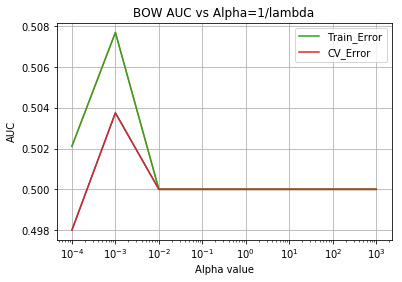

In [57]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=0.01 after that model started underfitting so AUC on train and Test data started decreasing. Hence our best alpha is 0.01 for l1 regularizer.

In [58]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=0.01
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(train_data, train_traget)

# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.01  AUC:  0.4900833333333333  Acc:  49.00833333333333


In [59]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

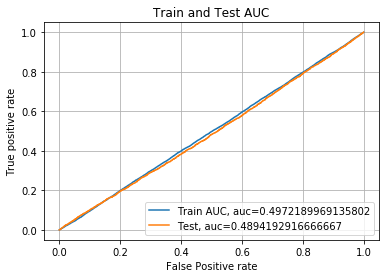

In [60]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =0.01. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

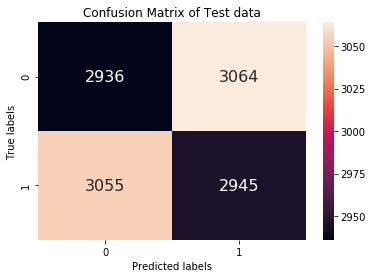

In [61]:
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

In [62]:
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.5090833333333333  Acc:  50.90833333333333  auc_train  0.50075



 12%|██████████▌                                                                         | 1/8 [00:00<00:01,  5.41it/s]

 C value:  0.001  AUC:  0.49924999999999997  Acc:  49.925000000000004  auc_train  0.5043333333333333



 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  5.70it/s]

 C value:  0.01  AUC:  0.5068333333333335  Acc:  50.68333333333334  auc_train  0.51075



 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:00,  5.99it/s]

 C value:  0.1  AUC:  0.5033333333333334  Acc:  50.33333333333333  auc_train  0.5080555555555556



 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00,  5.96it/s]

 C value:  1  AUC:  0.5  Acc:  50.0  auc_train  0.5000277777777777



 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:00<00:00,  6.19it/s]

 C value:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:00<00:00,  6.10it/s]

 C value:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:01<00:00,  5.88it/s]

 C value:  1000  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]

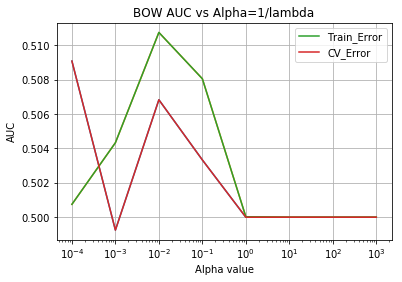

In [63]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is overfitting, means high AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=1 after that model started underfitting so AUC on train and Test data started decreasing. Hence our best alpha is 1 for l2 regularizer.


In [67]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_alpha=1
LGR = linear_model.SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2',n_jobs=-1)
LGR = CalibratedClassifierCV(LGR)
LGR.fit(train_data, train_traget)

# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha C:  1  AUC:  0.511  Acc:  51.1


In [68]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

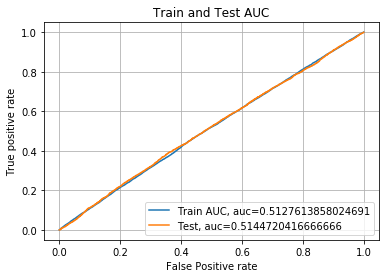

In [69]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =1. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

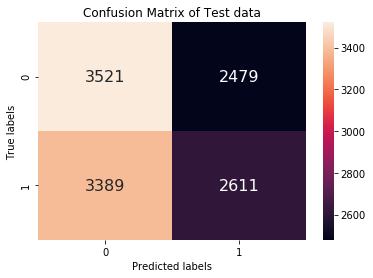

In [70]:
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [11]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
training_sample=train_text_data.sample(n=6000)
cv_sample=cv_text_data.sample(n=3000)
test_sample=test_text_data.sample(n=3000)


import gc; gc.collect()
# Converting text to vector using Bag of words to all train, CV and test
count_vect = CountVectorizer(min_df=10,max_features=300 ) #in scikit-learn
training_counts = count_vect.fit_transform(training_sample['CleanedText'])
cv_counts = count_vect.transform(cv_sample['CleanedText'])
test_counts = count_vect.transform(test_sample['CleanedText'])
gc.collect()

0

In [12]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()
train_traget=training_sample['Score'].astype('int')
cv_target=cv_sample['Score'].astype('int')
test_target=test_sample['Score'].astype('int')

 training_counts  (6000, 300) cv_counts  (3000, 300) test_counts (3000, 300)


In [13]:
# Compute train AUC also

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = SVC(C=i, kernel='rbf')

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.5  Acc:  48.266666666666666  auc_train  0.5



 12%|██████████▌                                                                         | 1/8 [00:32<03:46, 32.41s/it]

 C value:  0.001  AUC:  0.5  Acc:  48.266666666666666  auc_train  0.5



 25%|█████████████████████                                                               | 2/8 [01:04<03:14, 32.40s/it]

 C value:  0.01  AUC:  0.5  Acc:  48.266666666666666  auc_train  0.5



 38%|███████████████████████████████▌                                                    | 3/8 [01:37<02:41, 32.39s/it]

 C value:  0.1  AUC:  0.7330124736572308  Acc:  72.89999999999999  auc_train  0.7339139356557427



 50%|██████████████████████████████████████████                                          | 4/8 [02:06<02:05, 31.50s/it]

 C value:  1  AUC:  0.8188382838753774  Acc:  81.93333333333334  auc_train  0.8383353533414134



 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:27<01:25, 28.46s/it]

 C value:  10  AUC:  0.818355926411118  Acc:  81.86666666666666  auc_train  0.8771745086980347



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:44<00:49, 24.85s/it]

 C value:  100  AUC:  0.8104602152987412  Acc:  81.10000000000001  auc_train  0.9435107740430961



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [03:01<00:22, 22.52s/it]

 C value:  1000  AUC:  0.7861785897362875  Acc:  78.66666666666666  auc_train  0.992664637325216



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:21<00:00, 21.70s/it]

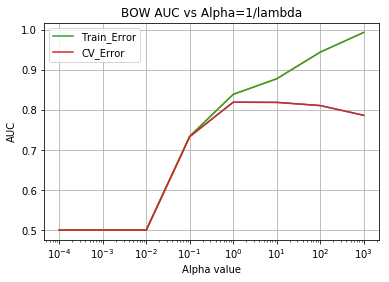

In [18]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As alpha increasing AUC on Unseen data increasing till best hyperparamter alpha=1 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best alpha is 1.

In [28]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_C=1
LGR = SVC(C=i, kernel='rbf')
LGR = CalibratedClassifierCV(LGR)
LGR.fit(training_count, train_traget)

# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  1  AUC:  0.7930287738944987  Acc:  79.26666666666667


In [29]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

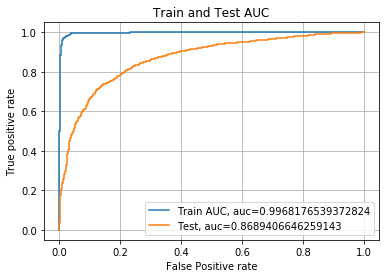

In [30]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is not overlapping on best hyperparamter alpha =1. And the diff of train and Test AUC is significant this is because our model is overfitting, and overfitting on RBF kernel because we have low training data, if we increase the data size this overfitness will go off.

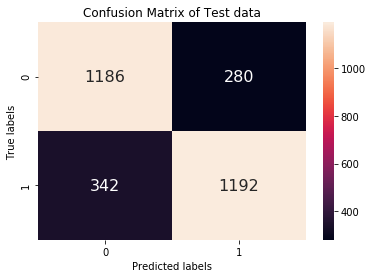

In [31]:
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [33]:
# Please write all the code with proper documentation

training_sample=train_text_data.sample(n=6000)
cv_sample=cv_text_data.sample(n=3000)
test_sample=test_text_data.sample(n=3000)

tf_idf_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=300)
training_counts = tf_idf_vect.fit_transform(training_sample['CleanedText'])
cv_counts = tf_idf_vect.transform(cv_sample['CleanedText'])
test_counts = tf_idf_vect.transform(test_sample['CleanedText'])
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
# converting sparse vector to dense vector
training_count=training_counts.toarray()
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()


 training_counts  (6000, 300) cv_counts  (3000, 300) test_counts (3000, 300)


0

In [34]:
gc.collect()
train_traget=training_sample['Score'].astype('int')
cv_target=cv_sample['Score'].astype('int')
test_target=test_sample['Score'].astype('int')

In [35]:
# Compute train AUC also

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = SVC(C=i, kernel='rbf')

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.5  Acc:  49.833333333333336  auc_train  0.5



 12%|██████████▌                                                                         | 1/8 [00:34<04:03, 34.72s/it]

 C value:  0.001  AUC:  0.5  Acc:  49.833333333333336  auc_train  0.5



 25%|█████████████████████                                                               | 2/8 [01:12<03:33, 35.53s/it]

 C value:  0.01  AUC:  0.5  Acc:  49.833333333333336  auc_train  0.5



 38%|███████████████████████████████▌                                                    | 3/8 [01:48<02:58, 35.66s/it]

 C value:  0.1  AUC:  0.5  Acc:  49.833333333333336  auc_train  0.5



 50%|██████████████████████████████████████████                                          | 4/8 [02:24<02:23, 35.76s/it]

 C value:  1  AUC:  0.5  Acc:  49.833333333333336  auc_train  0.5



 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:58<01:45, 35.25s/it]

 C value:  10  AUC:  0.7158468427426972  Acc:  71.63333333333334  auc_train  0.7136862822270332



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [03:28<01:07, 33.93s/it]

 C value:  100  AUC:  0.7106623406926743  Acc:  71.1  auc_train  0.7256599860147335



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [03:53<00:31, 31.11s/it]

 C value:  1000  AUC:  0.7030055889509883  Acc:  70.33333333333334  auc_train  0.7311028059315932



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:17<00:00, 28.82s/it]

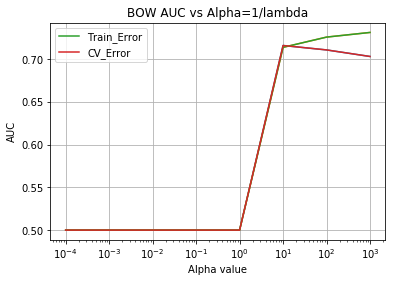

In [36]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As alpha increasing AUC on Unseen data increasing till best hyperparamter alpha=10 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best alpha is 10.


In [37]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_C=10
LGR = SVC(C=i, kernel='rbf')
LGR = CalibratedClassifierCV(LGR)
LGR.fit(training_count, train_traget)

# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  1  AUC:  0.7026057630083701  Acc:  70.3


In [38]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

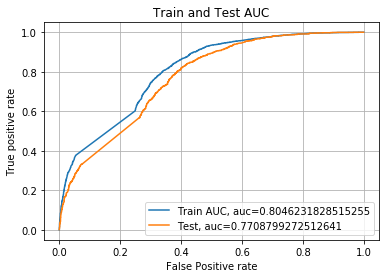

In [39]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =10. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features

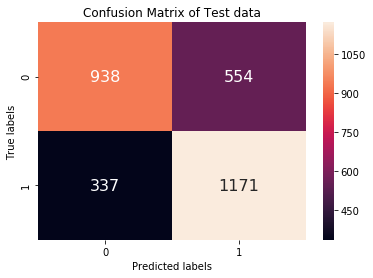

In [40]:
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [97]:
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
training_sample=train_avg_w2v_data.sample(n=6000)
cv_sample=cv_avg_w2v_data.sample(n=3000)
test_sample=test_avg_w2v_data.sample(n=3000)

train_traget=training_sample['Score'].astype('int')
cv_target=cv_sample['Score'].astype('int')
test_target=test_sample['Score'].astype('int')

train_data = training_sample.iloc[:,:-2]
cv_data = cv_sample.iloc[:,:-2]
test_data = test_sample.iloc[:,:-2]

In [98]:
# Please write all the code with proper documentation
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = SVC(C=i, kernel='rbf')

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.5  Acc:  49.766666666666666  auc_train  0.5




 12%|██████████▌                                                                         | 1/8 [00:05<00:39,  5.57s/it]

 C value:  0.001  AUC:  0.5  Acc:  49.766666666666666  auc_train  0.5




 25%|█████████████████████                                                               | 2/8 [00:11<00:34,  5.72s/it]

 C value:  0.01  AUC:  0.5  Acc:  49.766666666666666  auc_train  0.5




 38%|███████████████████████████████▌                                                    | 3/8 [00:17<00:28,  5.80s/it]

 C value:  0.1  AUC:  0.5033711845280187  Acc:  50.366666666666674  auc_train  0.5438681306080582




 50%|██████████████████████████████████████████                                          | 4/8 [00:23<00:23,  5.77s/it]

 C value:  1  AUC:  0.505529898206672  Acc:  50.56666666666667  auc_train  0.6041819351919712




 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:29<00:17,  5.82s/it]

 C value:  10  AUC:  0.5226407152866884  Acc:  52.26666666666666  auc_train  0.7258382114836496




 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:35<00:11,  5.87s/it]

 C value:  100  AUC:  0.5023053835394637  Acc:  50.23333333333333  auc_train  0.897838954595091




 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:45<00:07,  7.19s/it]

 C value:  1000  AUC:  0.49861530317771363  Acc:  49.86666666666667  auc_train  0.9955003313334806




100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:08<00:00, 11.86s/it]

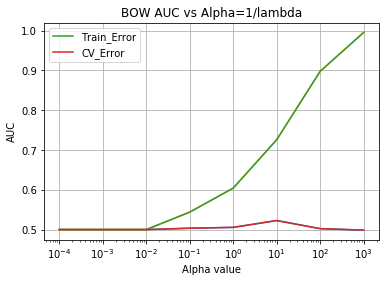

In [99]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is underfitting, means low AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=0.01 after that model started overfitting so AUC on train started increasing till 0.01. Hence our best alpha is 0.01

In [100]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_C=0.01
LGR = SVC(C=i, kernel='rbf')
LGR = CalibratedClassifierCV(LGR)
LGR.fit(train_data, train_traget)

# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.01  AUC:  0.5002587996321666  Acc:  50.06666666666667


In [101]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

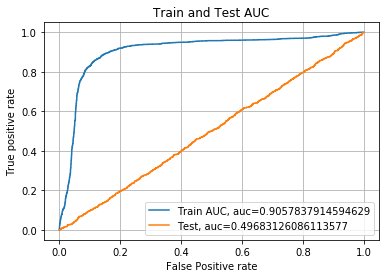

In [102]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is not overlapping on best hyperparamter alpha =0.01. And the diff of train and Test AUC is significant this is because our model is overfitting, and overfitting on RBF kernel because we have low training data, if we increase the data size this overfitness will go off.

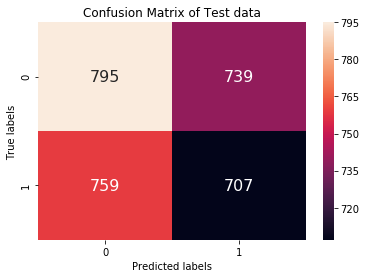

In [103]:
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [104]:
# Please write all the code with proper documentation

training_sample=train_tfidf_w2v_data.sample(n=6000)
cv_sample=cv_tfidf_w2v_data.sample(n=3000)
test_sample=test_tfidf_w2v_data.sample(n=3000)

train_traget=training_sample['Score'].astype('int')
cv_target=cv_sample['Score'].astype('int')
test_target=test_sample['Score'].astype('int')

train_data = training_sample.iloc[:,:-2]
cv_data = cv_sample.iloc[:,:-2]
test_data = test_sample.iloc[:,:-2]

In [105]:
# Please write all the code with proper documentation
# Compute train AUC also

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = SVC(C=i, kernel='rbf')

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.5  Acc:  49.9  auc_train  0.5




 12%|██████████▌                                                                         | 1/8 [00:06<00:44,  6.31s/it]

 C value:  0.001  AUC:  0.5  Acc:  49.9  auc_train  0.5




 25%|█████████████████████                                                               | 2/8 [00:12<00:37,  6.27s/it]

 C value:  0.01  AUC:  0.5  Acc:  49.9  auc_train  0.5




 38%|███████████████████████████████▌                                                    | 3/8 [00:18<00:31,  6.30s/it]

 C value:  0.1  AUC:  0.4940453095145714  Acc:  49.36666666666667  auc_train  0.5435516355302452




 50%|██████████████████████████████████████████                                          | 4/8 [00:24<00:24,  6.20s/it]

 C value:  1  AUC:  0.49780932457063165  Acc:  49.766666666666666  auc_train  0.6233571775817764




 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:30<00:18,  6.14s/it]

 C value:  10  AUC:  0.49873266159731305  Acc:  49.86666666666667  auc_train  0.7927342176540038




 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:37<00:12,  6.22s/it]

 C value:  100  AUC:  0.5060246907654298  Acc:  50.6  auc_train  0.963496076116397




 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:47<00:07,  7.51s/it]

 C value:  1000  AUC:  0.5013446720453548  Acc:  50.13333333333333  auc_train  0.9996666435169109




100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:03<00:00, 10.00s/it]

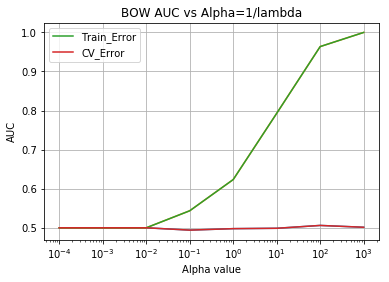

In [106]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs Alpha=1/lambda',C)
plt.show()

**Observation**

We can see that when alpha value is low, then our model is underfitting, means low AUC on train and comperatively low AUC on unseen data. As alpha is increasing, AUC on Unseen data increasing till best hyperparamter alpha=0.01 after that model started overfitting so AUC on train started increasing till 0.01. Hence our best alpha is 0.01

In [107]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
best_C=0.01
LGR = SVC(C=i, kernel='rbf')
LGR = CalibratedClassifierCV(LGR)
LGR.fit(train_data, train_traget)

# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.01  AUC:  0.5057941376959781  Acc:  50.93333333333333


In [111]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

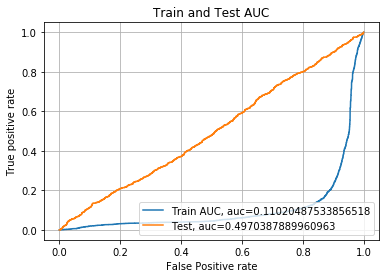

In [112]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is not overlapping on best hyperparamter alpha =0.01. And the diff of train and Test AUC is significant this is because our model is overfitting, and overfitting on RBF kernel because we have low training data, if we increase the data size this overfitness will go off.

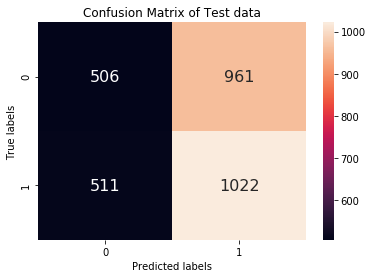

In [110]:
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.


# [6] Conclusions

In [13]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best alpha", "AUC"]

x.add_row(["BOW", "Linear_SVM_L1", 0.1, 0.91])
x.add_row(["BOW", "Linear_SVM_L2", 0.1, 0.92])
x.add_row(["BOW", "Kernel_SVM", 0.1, 0.87])
x.add_row(["TFIDF", "Linear_SVM_L1", 1, 0.92])
x.add_row(["TFIDF", "Linear_SVM_L2", 1, 0.93])
x.add_row(["TFIDF", "Kernel_SVM", 1, 0.85])
x.add_row(["AvgWord2Vec", "Linear_SVM_L1", 0.01, 0.51])
x.add_row(["AvgWord2Vec", "Linear_SVM_L2", 0.01, 0.51])
x.add_row(["AvgWord2Vec", "Kernel_SVM", 0.001, 0.50])
x.add_row(["TFIDFWord2Vec", "Linear_SVM_L1", 0.1, 0.50])
x.add_row(["TFIDFWord2Vec", "Linear_SVM_L2", 0.1, 0.50])
x.add_row(["TFIDFWord2Vec", "Kernel_SVM", 0.001, 0.51])
print(x)

+---------------+---------------+------------+------+
|   Vectorizer  |     Model     | Best alpha | AUC  |
+---------------+---------------+------------+------+
|      BOW      | Linear_SVM_L1 |    0.1     | 0.91 |
|      BOW      | Linear_SVM_L2 |    0.1     | 0.92 |
|      BOW      |   Kernel_SVM  |    0.1     | 0.87 |
|     TFIDF     | Linear_SVM_L1 |     1      | 0.92 |
|     TFIDF     | Linear_SVM_L2 |     1      | 0.93 |
|     TFIDF     |   Kernel_SVM  |     1      | 0.85 |
|  AvgWord2Vec  | Linear_SVM_L1 |    0.01    | 0.51 |
|  AvgWord2Vec  | Linear_SVM_L2 |    0.01    | 0.51 |
|  AvgWord2Vec  |   Kernel_SVM  |   0.001    | 0.5  |
| TFIDFWord2Vec | Linear_SVM_L1 |    0.1     | 0.5  |
| TFIDFWord2Vec | Linear_SVM_L2 |    0.1     | 0.5  |
| TFIDFWord2Vec |   Kernel_SVM  |   0.001    | 0.51 |
+---------------+---------------+------------+------+


**Observation**

We can see that with all 12 type of models TFIDF vectorizer with l2 regularizer performing better with maximum AUC 93% on test data.BOW based vectorizer gave 2nd best solution with aprrox same AUC on l2 regularization, kernel SVM would have worked better if we increase the training data, but it takes alot of time, so sampled the small dataset for training RBF SVM . On the other word2vec vectorizer on both avg and TFIDF performing worst and similar to random model.
